In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import savemat
from scipy import signal
from ordpy import renyi_complexity_entropy as RE
from ordpy import renyi_entropy
from ordpy import permutation_entropy
from neurodsp.burst import detect_bursts_dual_threshold as DBDT
from neurodsp.burst import compute_burst_stats
import scipy.stats 
from scipy.stats import mannwhitneyu
from scipy.stats import wilcoxon
from scipy import stats
import mne
sns.set_theme()
%matplotlib inline

In [66]:
def read_file(path, order):
    frame = pd.read_csv(path, delimiter=',\s+', comment='%')
    info = mne.create_info(['channel3', 'channel5', 'trigger'], ch_types=['eeg', 'eeg', 'stim'], sfreq=250)
    data = frame.values.T[order]
    data[-1] = (data[-1] == 1).astype(int) 
    raw = mne.io.RawArray(data, info)
    raw = raw.filter(l_freq=1, h_freq=80)
    raw = raw.notch_filter(50)
    events = mne.find_events(raw, output='step')
    
    start = events[::2, 0]
    types = events[::2, 2]
    times = events[1::2, 0] - start
    types[np.abs(times-25) < 5] = 0
    types[np.abs(times-50) < 5] = 1
    types[np.abs(times-75) < 5] = 2

    middle = np.zeros(start.shape[0], dtype=int)
    events = np.concatenate([start[None], middle[None], types[None]], axis=0).T
    epochs = mne.Epochs(raw, events, tmin=-.2, tmax=2, baseline=(-.2, 0))
    return epochs


def compute_ci(data, confidence=0.95):
    n = data.shape[0]
    m, se = data.mean(axis=0), stats.sem(data, axis=0)
    h = se * stats.t.ppf((1 + confidence) / 2., n-1)
    return m, h


def plot_epochs(ax, epochs, event, channel):
    data = epochs[event].get_data(copy=True)[:, channel]
    mean, ci = compute_ci(data)
    x = np.arange(data.shape[1]) / 250 - .2
    ax.plot(x, mean)
    ax.fill_between(x, mean-ci, mean+ci, alpha=.3)



def permutation_test(group1, group2, num_permutations=10000):
    
    obs_statistic = np.mean(group1) - np.mean(group2)
    
    # Combine the data
    combined_data = np.concatenate([group1, group2])
    
    # Initialize an array to store permuted statistics
    permuted_stats = np.zeros(num_permutations)
    
    # Perform permutations
    for i in range(num_permutations):
        # Permute the combined data
        permuted_data = np.random.permutation(combined_data)
        
        # Split permuted data into two groups
        perm_group1 = permuted_data[:len(group1)]
        perm_group2 = permuted_data[len(group1):]
        
        # Calculate the permutation statistic
        permuted_stats[i] = np.mean(perm_group1) - np.mean(perm_group2)
    
    # Calculate p-value
    p_value = np.sum(np.abs(permuted_stats) >= np.abs(obs_statistic)) / num_permutations
    
    return p_value

In [63]:
def process_finche(files, order):
    epochs = [read_file(x, order) for x in files]
    epochs = mne.concatenate_epochs(epochs)

    for channel in [0, 1]:
        for group1, group2 in [('0', '1'), ('0', '2'), ('1', '2')]:
            A = epochs[group1].get_data(copy=True)[:, channel, 51:].mean(axis=1)
            B = epochs[group2].get_data(copy=True)[:, channel, 51:].mean(axis=1)
            result = permutation_test(A, B)
            print(f'Channel: {channel}, Group1: {group1}, Group2: {group2}, p-value: {result}')
    return epochs 



In [64]:
file1 = 'Data/F1_1/F1_1.Txt'
file2 = 'Data/F1_2/F1_2.Txt'
file3 = 'Data/F1_3/F1_3.Txt'


In [18]:
epochs = process_finche([file1, file2, file3], [3, 5, 16])



C:\Users\DFM-RENDERING\AppData\Local\Temp\ipykernel_21316\2296184640.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  frame = pd.read_csv(path, delimiter=',\s+', comment='%')


Creating RawArray with float64 data, n_channels=3, n_times=99966
    Range : 0 ... 99965 =      0.000 ...   399.860 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 90.00 Hz)
- Filter length: 825 samples (3.300 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenua

C:\Users\DFM-RENDERING\AppData\Local\Temp\ipykernel_21316\2296184640.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  frame = pd.read_csv(path, delimiter=',\s+', comment='%')


Creating RawArray with float64 data, n_channels=3, n_times=258641
    Range : 0 ... 258640 =      0.000 ...  1034.560 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 90.00 Hz)
- Filter length: 825 samples (3.300 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband atten

C:\Users\DFM-RENDERING\AppData\Local\Temp\ipykernel_21316\2296184640.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  frame = pd.read_csv(path, delimiter=',\s+', comment='%')


Creating RawArray with float64 data, n_channels=3, n_times=516395
    Range : 0 ... 516394 =      0.000 ...  2065.576 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 90.00 Hz)
- Filter length: 825 samples (3.300 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband atten

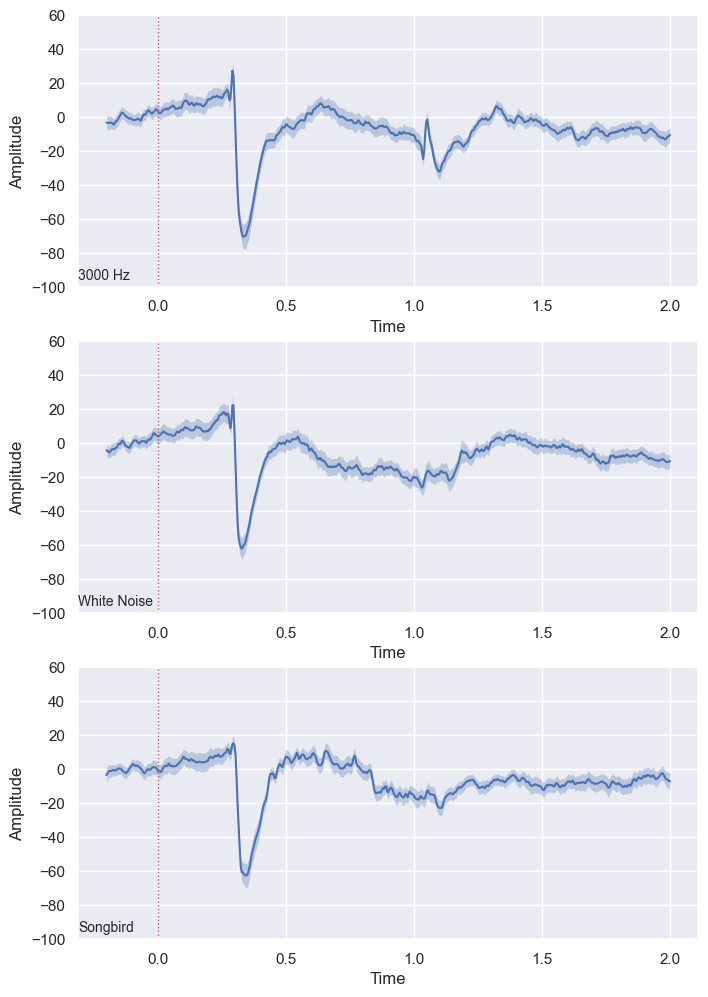

In [57]:
fig, ax = plt.subplots(3, 1, figsize=(8, 12))
plot_epochs(ax[0], epochs, '0', 0)
ax[0].set_title('3000 Hz', fontsize=10,  y=0.1, pad=-14,loc = 'left')
ax[0].set_ylim([-100, +60])
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Amplitude')
ax[0].axvline(x=0, color='r', linewidth=1, linestyle=':', label='Onset_3000 Hz')
  

plot_epochs(ax[1], epochs, '1', 0)
ax[1].set_title('White Noise', fontsize=10,  y=0.1, pad=-14,loc = 'left')
ax[1].set_ylim([-100, +60])
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Amplitude')
ax[1].axvline(x=0, color='r', linewidth=1, linestyle=':', label='Onset_3000 Hz')


plot_epochs(ax[2], epochs, '2', 0)
ax[2].set_title('Songbird', fontsize=10,  y=0.1, pad=-14,loc = 'left')
ax[2].set_ylim([-100, +60])
ax[2].set_xlabel('Time')
ax[2].set_ylabel('Amplitude')
ax[2].axvline(x=0, color='r', linewidth=1, linestyle=':', label='Onset_3000 Hz')

plt.savefig('fig/ERP1_Frontal.pdf', format='pdf', dpi=1500)


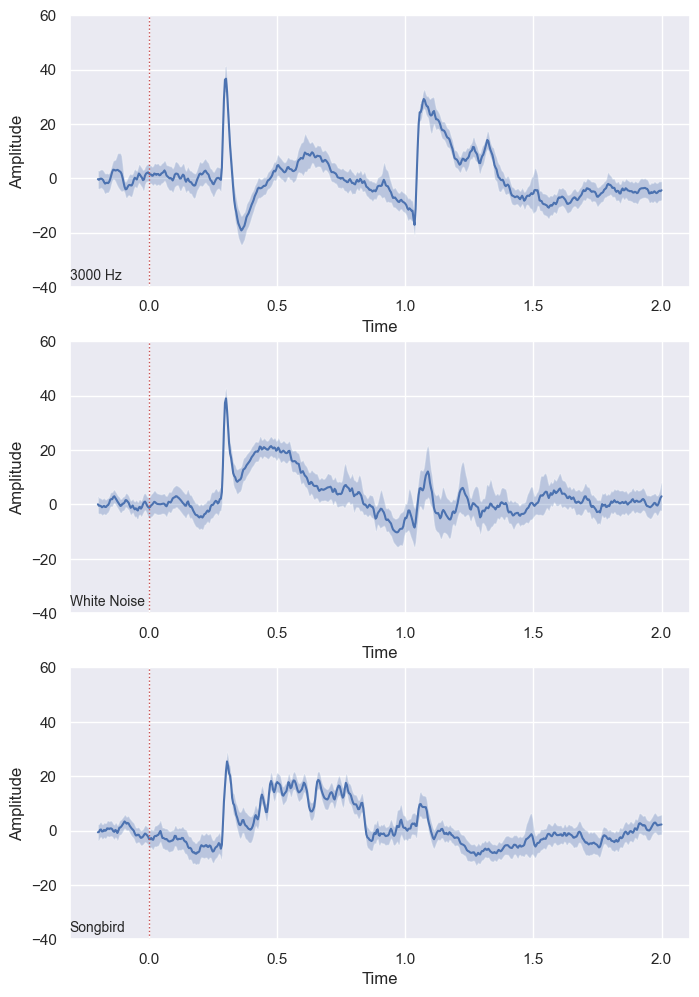

In [59]:
fig, ax = plt.subplots(3, 1, figsize=(8, 12))
plot_epochs(ax[0], epochs, '0', 1)
ax[0].set_title('3000 Hz', fontsize=10,  y=0.1, pad=-14,loc = 'left')
ax[0].set_ylim([-40, +60])
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Amplitude')
ax[0].axvline(x=0, color='r', linewidth=1, linestyle=':', label='Onset_3000 Hz')
  

plot_epochs(ax[1], epochs, '1', 1)
ax[1].set_title('White Noise', fontsize=10,  y=0.1, pad=-14,loc = 'left')
ax[1].set_ylim([-40, +60])
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Amplitude')
ax[1].axvline(x=0, color='r', linewidth=1, linestyle=':', label='Onset_3000 Hz')


plot_epochs(ax[2], epochs, '2', 1)
ax[2].set_title('Songbird', fontsize=10,  y=0.1, pad=-14,loc = 'left')
ax[2].set_ylim([-40, +60])
ax[2].set_xlabel('Time')
ax[2].set_ylabel('Amplitude')
ax[2].axvline(x=0, color='r', linewidth=1, linestyle=':', label='Onset_3000 Hz')

plt.savefig('fig/ERP2_Frontal.pdf', format='pdf', dpi=1500)

In [24]:
file1 = 'Data/F2_1/F2_1.Txt'
file2 = 'Data/F2_2/F2_2.Txt'


In [25]:
process_finche([file1, file2], [5, 3, 16])

C:\Users\DFM-RENDERING\AppData\Local\Temp\ipykernel_3596\311643865.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  frame = pd.read_csv(path, delimiter=',\s+', comment='%')


Creating RawArray with float64 data, n_channels=3, n_times=485575
    Range : 0 ... 485574 =      0.000 ...  1942.296 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 90.00 Hz)
- Filter length: 825 samples (3.300 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband atten

C:\Users\DFM-RENDERING\AppData\Local\Temp\ipykernel_3596\311643865.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  frame = pd.read_csv(path, delimiter=',\s+', comment='%')


Creating RawArray with float64 data, n_channels=3, n_times=474710
    Range : 0 ... 474709 =      0.000 ...  1898.836 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 90.00 Hz)
- Filter length: 825 samples (3.300 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband atten

Number of events,600
Events,0: 2001: 2002: 200
Time range,-0.200 – 2.000 s
Baseline,-0.200 – 0.000 s


In [ ]:
# epochs.save('Temp/finche-2-epo.fif')
epochs = mne.read_epochs('Temp/finche-2-epo.fif')

In [ ]:
epochs

Number of events,600
Events,0: 2001: 2002: 200
Time range,-0.200 – 2.000 s
Baseline,-0.200 – 0.000 s


In [ ]:
def band_filter(data, low, high, rate):
    b, a = signal.butter(4, [low/(rate/2), high/(rate/2)], btype='band')
    return signal.filtfilt(b, a, data)


def notch_filter(data, freq, rate):
    b, a = signal.iirnotch(freq, 30, fs=rate)
    return signal.filtfilt(b, a, data)


def filter_data(data):
    temp = band_filter(data, 1, 80, 250)
    temp = notch_filter(temp, 50, 250)
    return temp


def read_file(path):
    frame = pd.read_csv(path, delimiter=',\s+', comment='%')
    data = frame.loc[:, ['EXG Channel 2', 'EXG Channel 4', 'Accel Channel 0','Accel Channel 1', 'Accel Channel 2']].values.T
    for i in range(len(data)): data[i] = filter_data(data[i])
    return data
    

In [ ]:


def band_filter(data, low, high, rate):
    b, a = signal.butter(4, [low/(rate/2), high/(rate/2)], btype='band')
    return signal.filtfilt(b, a, data)


def notch_filter(data, freq, rate):
    b, a = signal.iirnotch(freq, 30, fs=rate)
    return signal.filtfilt(b, a, data)


def filter_data(data):
    temp = band_filter(data, 1, 80, 250)
    temp = notch_filter(temp, 50, 250)
    return temp


def read_file(path):
    frame = pd.read_csv(path, delimiter=',\s+', comment='%')
    data = frame.loc[:, ['EXG Channel 2', 'EXG Channel 4', 'Accel Channel 0','Accel Channel 1', 'Accel Channel 2']].values.T
    for i in range(len(data)): data[i] = filter_data(data[i])
    return data

# This function will check for the specific group sizes
def find_first_of_groups(arr, sizes):
    # Initializations
    start_indices = []
    count = 0
    in_group = False

    for i, value in enumerate(arr):
        if value == 1:
            if not in_group:
                # Start of a new group
                start = i
                in_group = True
            count += 1
        else:
            if in_group:
                # End of a group, check its size
                if count in sizes:
                    start_indices.append(start)
                # Reset for the next group
                in_group = False
                count = 0
    
    # Check for a group ending at the end of the array
    if in_group and count in sizes:
        start_indices.append(start)

    return start_indices

def Epoch_data(data, trigger, lenght = 125, baseLine = 125):
    
    
    output = []
    for onset in trigger:
        end =  lenght + onset 
        output.append(np.r_[(data[onset:baseLine+onset] - data[(onset-baseLine):onset]),data[(onset+baseLine+1):end]])
        
    return output

def Epoch_mean(data, trigger, lenght = 125, baseLine = 125):
    
    
    output = []
    for onset in trigger:
        end =  lenght + onset 
        output.append(np.mean(np.r_[(data[onset:baseLine+onset] - data[(onset-baseLine):onset]),data[(onset+baseLine+1):end]]))
        
    return output
    
    
    # permutation test
def permutation_test(group1, group2, num_permutations=10000):
    
    obs_statistic = np.mean(group1) - np.mean(group2)
    
    # Combine the data
    combined_data = np.concatenate([group1, group2])
    
    # Initialize an array to store permuted statistics
    permuted_stats = np.zeros(num_permutations)
    
    # Perform permutations
    for i in range(num_permutations):
        # Permute the combined data
        permuted_data = np.random.permutation(combined_data)
        
        # Split permuted data into two groups
        perm_group1 = permuted_data[:len(group1)]
        perm_group2 = permuted_data[len(group1):]
        
        # Calculate the permutation statistic
        permuted_stats[i] = np.mean(perm_group1) - np.mean(perm_group2)
    
    # Calculate p-value
    p_value = np.sum(np.abs(permuted_stats) >= np.abs(obs_statistic)) / num_permutations
    
    return p_value



def trim_data(data, trim_percentage = 5):
        
    trimmed_data = []
    for j in range(data.shape[1]):
        
        
        num_trim = int(data.shape[0] * trim_percentage / 100)
        sorted_row = np.sort(data[:,j])
        trimmed_row = sorted_row[num_trim:-num_trim]
        
        trimmed_data.append(trimmed_row)

    trimmed_data = np.array(trimmed_data).T
    

    return trimmed_data




In [ ]:
path = 'Data/F1_1/F1_1.Txt'    # 3 is front
path1 = 'Data/F1_2/F1_2.Txt'
path2 = 'Data/F1_3/F1_3.Txt'
#path = 'Data/F2_1/F2_1.Txt'
#path = 'Data/F2_2/F2_2.Txt'

data11 = pd.read_csv(path, delimiter=',\s+', comment='%').values.T
data12 = pd.read_csv(path1, delimiter=',\s+', comment='%').values.T
data13 = pd.read_csv(path2, delimiter=',\s+', comment='%').values.T


C:\Users\DFM-RENDERING\AppData\Local\Temp\ipykernel_24880\441511546.py:7: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  data11 = pd.read_csv(path, delimiter=',\s+', comment='%').values.T
C:\Users\DFM-RENDERING\AppData\Local\Temp\ipykernel_24880\441511546.py:8: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  data12 = pd.read_csv(path1, delimiter=',\s+', comment='%').values.T
C:\Users\DFM-RENDERING\AppData\Local\Temp\ipykernel_24880\441511546.py:9: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are int

In [ ]:
data0 = [filter_data(data11[3,:]),filter_data(data11[5,:]), data11[16,:]] #seclecting the targeted electrodes and the trigger electrode
data2 = [filter_data(data12[3,:]),filter_data(data12[5,:]), data12[16,:]]
data3 = [filter_data(data13[3,:]),filter_data(data13[5,:]), data13[16,:]]

data1 = np.concatenate((data0, data2, data3), axis = 1)
np.shape(data1)

(3, 875002)

In [ ]:
first_ones_indices25 = find_first_of_groups(data1[2], [24,25,26])
first_ones_indices50 = find_first_of_groups(data1[2], [48,49,50,51,52])
first_ones_indices75 = find_first_of_groups(data1[2], [73,74,75,76,77])



In [ ]:
Epoch25 =  np.array(Epoch_data(data1[0],first_ones_indices25, 500) , dtype= float)
Epoch50 =  np.array(Epoch_data(data1[0],first_ones_indices50, 500), dtype= float)
Epoch75 =  np.array(Epoch_data(data1[0],first_ones_indices75 , 500), dtype= float)

Epoch255 =  np.array(Epoch_data(data1[1],first_ones_indices25, 500) , dtype= float)
Epoch500 =  np.array(Epoch_data(data1[1],first_ones_indices50, 500), dtype= float)
Epoch755 =  np.array(Epoch_data(data1[1],first_ones_indices75, 500), dtype= float)
np.shape(Epoch25)

(140, 499)

In [ ]:
Avg_Epoch2 = Epoch_mean(data1[0],first_ones_indices25 ) 
Avg_Epoch5 = Epoch_mean(data1[0],first_ones_indices50)
Avg_Epoch7 = Epoch_mean(data1[0],first_ones_indices75 )

Avg_Epoch22 = Epoch_mean(data1[1],first_ones_indices25) 
Avg_Epoch55 = Epoch_mean(data1[1],first_ones_indices50)
Avg_Epoch77 = Epoch_mean(data1[1],first_ones_indices75)
np.shape(Avg_Epoch2)

(140,)

In [ ]:
print(stats.describe(Avg_Epoch2))
print(stats.describe(Avg_Epoch5))
print(stats.describe(Avg_Epoch7))

print(stats.describe(Avg_Epoch22))
print(stats.describe(Avg_Epoch55))
print(stats.describe(Avg_Epoch77))

DescribeResult(nobs=140, minmax=(-16.030862536056347, 14.710730576308523), mean=-1.7067420933805486, variance=37.49246095311886, skewness=0.19057537124343907, kurtosis=-0.16493136068487013)
DescribeResult(nobs=140, minmax=(-18.43965617892164, 16.71989679040198), mean=-0.29897563548847034, variance=54.634372976591216, skewness=0.19239256677676864, kurtosis=-0.3453600616585546)
DescribeResult(nobs=140, minmax=(-23.27294349145068, 13.66350655014081), mean=-3.0313905546373427, variance=36.397836821925246, skewness=-0.2577092820926718, kurtosis=0.37689977512443695)
DescribeResult(nobs=140, minmax=(-27.170473503870756, 18.643138010765313), mean=-0.48432401558499877, variance=31.47056645050976, skewness=-0.2927580039840011, kurtosis=3.358851340568628)
DescribeResult(nobs=140, minmax=(-15.295495410390568, 20.437714409579613), mean=-0.6955561184479528, variance=32.01319542168054, skewness=0.6135710908150402, kurtosis=0.7107722744832636)
DescribeResult(nobs=140, minmax=(-17.472211372408395, 10.8

In [ ]:

print(stats.ttest_ind(Avg_Epoch2 , Avg_Epoch5).pvalue,stats.ttest_ind(Avg_Epoch2 , Avg_Epoch7).pvalue,stats.ttest_ind(Avg_Epoch7 , Avg_Epoch5).pvalue) 
print(stats.ttest_ind(Avg_Epoch22 , Avg_Epoch55).pvalue,stats.ttest_ind(Avg_Epoch22 , Avg_Epoch77).pvalue,stats.ttest_ind(Avg_Epoch77 , Avg_Epoch55).pvalue) 

0.08377672455263915 0.06932360410721587 0.000804297855644213
0.7539961578529373 0.0004776355200519259 0.0015584495468709762


In [ ]:
# Perform permutation test
permutation_p_value = permutation_test(Avg_Epoch2, Avg_Epoch5)
print("Permutation Test p-value:", permutation_p_value)
permutation_p_value = permutation_test(Avg_Epoch7, Avg_Epoch2)
print("Permutation Test p-value:", permutation_p_value)
permutation_p_value = permutation_test(Avg_Epoch5, Avg_Epoch7)
print("Permutation Test p-value:", permutation_p_value)


# Perform permutation test
permutation_p_value = permutation_test(Avg_Epoch22, Avg_Epoch55)
print("Permutation Test p-value:", permutation_p_value)
permutation_p_value = permutation_test(Avg_Epoch77, Avg_Epoch22)
print("Permutation Test p-value:", permutation_p_value)
permutation_p_value = permutation_test(Avg_Epoch55, Avg_Epoch77)
print("Permutation Test p-value:", permutation_p_value)



Permutation Test p-value: 0.0806
Permutation Test p-value: 0.0716
Permutation Test p-value: 0.0015
Permutation Test p-value: 0.756
Permutation Test p-value: 0.0005
Permutation Test p-value: 0.0009


In [ ]:
print(len(Epoch25)+len(Epoch50)+len(Epoch75)) #checking the trigger count

420


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


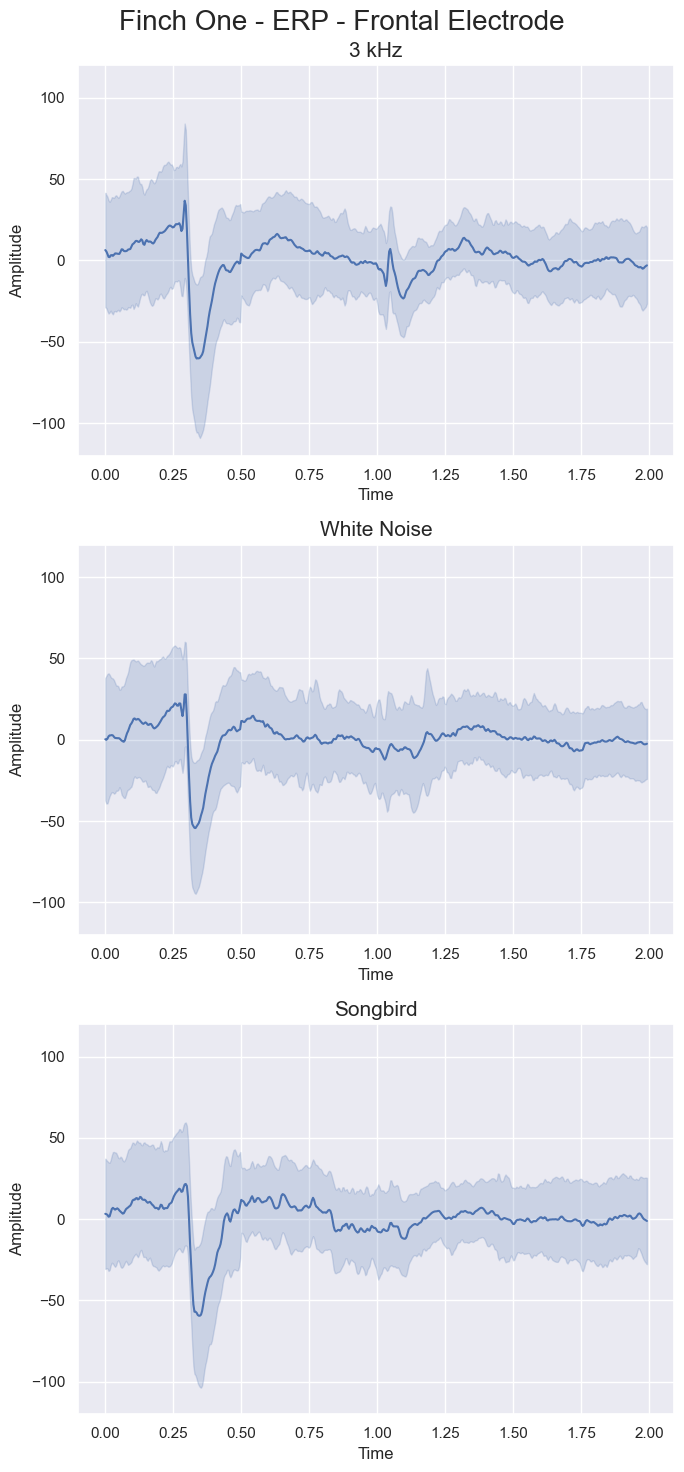

In [ ]:
sns.set()

fig, axs = plt.subplots(3, 1, figsize=(7, 15), tight_layout=False)

# Set titles for each plot
axs[0].plot(np.arange(Epoch25.shape[1])/250, np.mean(Epoch25, axis=0),'b-', label='Mean 3k')
axs[0].fill_between( np.arange(Epoch25.shape[1])/250, (np.mean(Epoch25, axis=0) - np.std(Epoch25, axis =0)), (np.mean(Epoch25, axis=0) + np.std(Epoch25, axis =0)), color='b', alpha=0.2)
axs[0].set_title('3 kHz', fontsize=15)
axs[0].set_ylim([-120, +120])
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Amplitude')



axs[1].plot(np.arange(Epoch25.shape[1])/250,np.mean(Epoch50, axis=0))
axs[1].fill_between( np.arange(Epoch25.shape[1])/250, (np.mean(Epoch50, axis=0) - np.std(Epoch50, axis =0)), (np.mean(Epoch50, axis=0) + np.std(Epoch50, axis =0)), color='b', alpha=0.2)

axs[1].set_title('White Noise', fontsize=15)
axs[1].set_ylim([-120, +120])
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Amplitude')

axs[2].plot(np.arange(Epoch25.shape[1])/250,np.mean(Epoch75, axis=0))
axs[2].fill_between(np.arange(Epoch25.shape[1])/250, (np.mean(Epoch75, axis=0) - np.std(Epoch75, axis =0)), (np.mean(Epoch75, axis=0) + np.std(Epoch75, axis =0)), color='b', alpha=0.2)
axs[2].set_title('Songbird', fontsize=15)
axs[2].set_ylim([-120, +120])
axs[2].set_xlabel('Time')
axs[2].set_ylabel('Amplitude')

# Set title for the whole figure
fig.suptitle('Finch One - ERP - Frontal Electrode', fontsize=20)
plt.savefig('fig/ERP1_Frontal.eps', format='eps', dpi=700)

plt.show()



The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


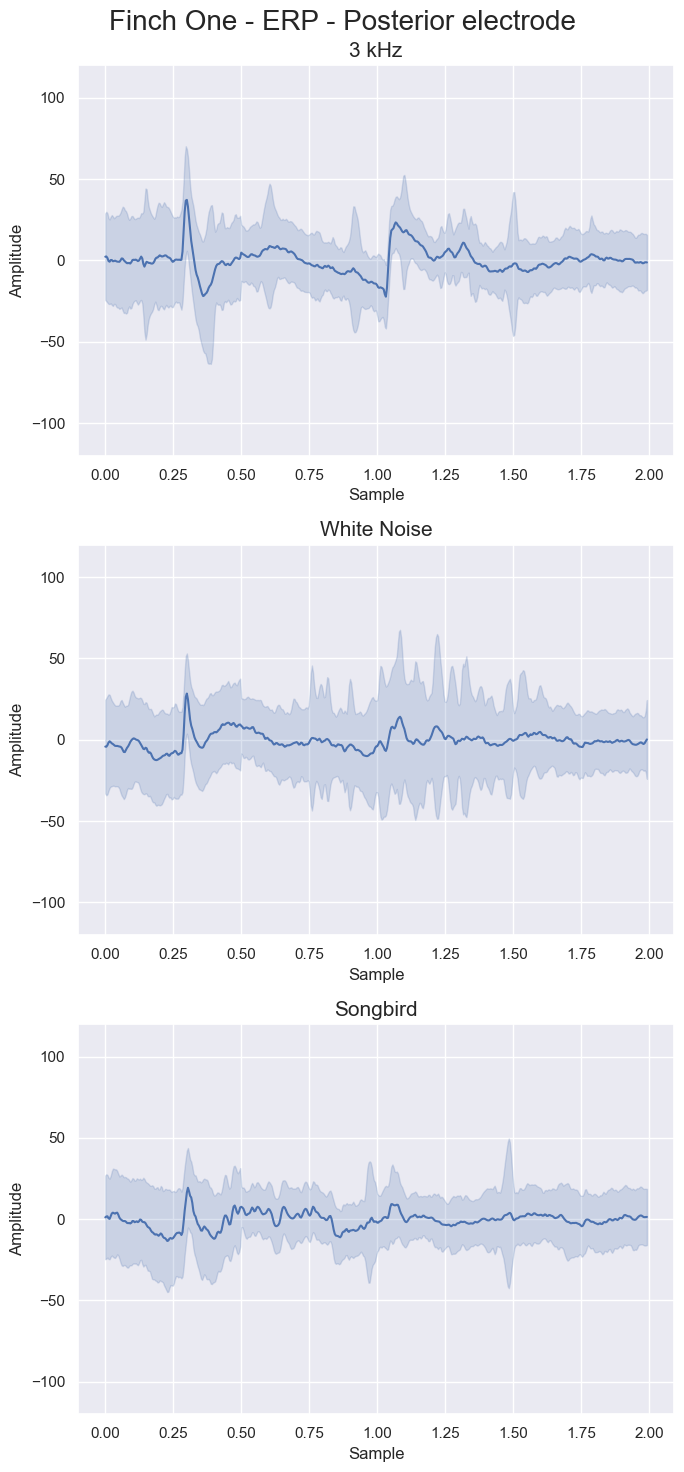

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=(7, 15), tight_layout=False)

# Set titles for each plot
axs[0].plot(np.arange(Epoch25.shape[1])/250,np.mean(Epoch255, axis=0))
axs[0].fill_between( np.arange(Epoch25.shape[1])/250, (np.mean(Epoch255, axis=0) - np.std(Epoch255, axis =0)), (np.mean(Epoch255, axis=0) + np.std(Epoch255, axis =0)), color='b', alpha=0.2)

axs[0].set_title('3 kHz', fontsize=15)
axs[0].set_ylim([-120, +120])
axs[0].set_xlabel('Sample')
axs[0].set_ylabel('Amplitude')

axs[1].plot(np.arange(Epoch25.shape[1])/250,np.mean(Epoch500, axis=0))
axs[1].set_title('White Noise', fontsize=15)
axs[1].fill_between( np.arange(Epoch25.shape[1])/250, (np.mean(Epoch500, axis=0) - np.std(Epoch500, axis =0)), (np.mean(Epoch500, axis=0) + np.std(Epoch500, axis =0)), color='b', alpha=0.2)

axs[1].set_ylim([-120, +120])

axs[1].set_xlabel('Sample')
axs[1].set_ylabel('Amplitude')

axs[2].plot(np.arange(Epoch25.shape[1])/250,np.mean(Epoch755, axis=0))
axs[2].fill_between( np.arange(Epoch25.shape[1])/250, (np.mean(Epoch755, axis=0) - np.std(Epoch755, axis =0)), (np.mean(Epoch755, axis=0) + np.std(Epoch755, axis =0)), color='b', alpha=0.2)

axs[2].set_title('Songbird', fontsize=15)
axs[2].set_ylim([-120, +120])

axs[2].set_xlabel('Sample')
axs[2].set_ylabel('Amplitude')

# Set title for the whole figure
fig.suptitle('Finch One - ERP - Posterior electrode', fontsize=20)
plt.savefig('fig/ERP1_posterior.eps', format='eps', dpi=700)

plt.show()


In [ ]:
path4 = 'Data/F2_1/F2_1.Txt'
path5 = 'Data/F2_2/F2_2.Txt'

data4 = pd.read_csv(path4, delimiter=',\s+', comment='%').values.T
data5= pd.read_csv(path5, delimiter=',\s+', comment='%').values.T


C:\Users\DFM-RENDERING\AppData\Local\Temp\ipykernel_24880\122170137.py:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  data4 = pd.read_csv(path4, delimiter=',\s+', comment='%').values.T
C:\Users\DFM-RENDERING\AppData\Local\Temp\ipykernel_24880\122170137.py:5: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  data5= pd.read_csv(path5, delimiter=',\s+', comment='%').values.T


In [ ]:
data44 = [filter_data(data4[5,:]),filter_data(data4[3,:]), data4[16,:]] #seclecting the targeted electrodes and the trigger electrode
data55 = [filter_data(data5[5,:]),filter_data(data5[3,:]), data5[16,:]]

data21 = np.concatenate((data44,data55) , axis = 1)

In [ ]:
np.shape(data21)

(3, 960285)

In [ ]:
first_ones_indices25_2 = find_first_of_groups(data21[2], [24,25,26])
first_ones_indices50_2 = find_first_of_groups(data21[2], [48,49,50,51,52])
first_ones_indices75_2 = find_first_of_groups(data21[2], [73,74,75,76,77])



In [ ]:
Epoch25_2 =np.array(Epoch_data(data21[0],first_ones_indices25_2, 500) , dtype = float)
Epoch50_2 = np.array(Epoch_data(data21[0],first_ones_indices50_2, 500), dtype = float)
Epoch75_2 = np.array(Epoch_data(data21[0],first_ones_indices75_2, 500), dtype = float)

Epoch255_2 = np.array(Epoch_data(data21[1],first_ones_indices25_2, 500) , dtype = float)
Epoch500_2 = np.array(Epoch_data(data21[1],first_ones_indices50_2, 500), dtype = float)
Epoch755_2 = np.array(Epoch_data(data21[1],first_ones_indices75_2, 500), dtype = float)

In [ ]:
Epoch25_2 = trim_data(np.array(Epoch_data(data21[0],first_ones_indices25_2, 500) , dtype = float), 25 )
Epoch50_2 = trim_data(np.array(Epoch_data(data21[0],first_ones_indices50_2, 500), dtype = float), 25)
Epoch75_2 = trim_data(np.array(Epoch_data(data21[0],first_ones_indices75_2, 500), dtype = float), 25)

Epoch255_2 = trim_data(np.array(Epoch_data(data21[1],first_ones_indices25_2, 500) , dtype = float), 25)
Epoch500_2 = trim_data(np.array(Epoch_data(data21[1],first_ones_indices50_2, 500), dtype = float), 25)
Epoch755_2 = trim_data(np.array(Epoch_data(data21[1],first_ones_indices75_2, 500), dtype = float), 25)
np.shape(Epoch25_2)

(100, 499)

In [ ]:
Avg_Epoch2_2 = Epoch_mean(data21[0],first_ones_indices25_2) 
Avg_Epoch5_2 = Epoch_mean(data21[0],first_ones_indices50_2)
Avg_Epoch7_2 = Epoch_mean(data21[0],first_ones_indices75_2)

Avg_Epoch22_2 = Epoch_mean(data21[1],first_ones_indices25_2) 
Avg_Epoch55_2 = Epoch_mean(data21[1],first_ones_indices50_2)
Avg_Epoch77_2 = Epoch_mean(data21[1],first_ones_indices75_2)


In [ ]:
print(stats.describe(Avg_Epoch2))
print(stats.describe(Avg_Epoch5))
print(stats.describe(Avg_Epoch7))

print(stats.describe(Avg_Epoch22))
print(stats.describe(Avg_Epoch55))
print(stats.describe(Avg_Epoch77))

DescribeResult(nobs=140, minmax=(-16.030862536056347, 14.710730576308523), mean=-1.7067420933805486, variance=37.49246095311886, skewness=0.19057537124343907, kurtosis=-0.16493136068487013)
DescribeResult(nobs=140, minmax=(-18.43965617892164, 16.71989679040198), mean=-0.29897563548847034, variance=54.634372976591216, skewness=0.19239256677676864, kurtosis=-0.3453600616585546)
DescribeResult(nobs=140, minmax=(-23.27294349145068, 13.66350655014081), mean=-3.0313905546373427, variance=36.397836821925246, skewness=-0.2577092820926718, kurtosis=0.37689977512443695)
DescribeResult(nobs=140, minmax=(-27.170473503870756, 18.643138010765313), mean=-0.48432401558499877, variance=31.47056645050976, skewness=-0.2927580039840011, kurtosis=3.358851340568628)
DescribeResult(nobs=140, minmax=(-15.295495410390568, 20.437714409579613), mean=-0.6955561184479528, variance=32.01319542168054, skewness=0.6135710908150402, kurtosis=0.7107722744832636)
DescribeResult(nobs=140, minmax=(-17.472211372408395, 10.8

In [ ]:
permutation_p_value = permutation_test(Avg_Epoch2_2, Avg_Epoch5_2)
print("Permutation Test p-value:", permutation_p_value)
permutation_p_value = permutation_test(Avg_Epoch7_2, Avg_Epoch2_2)
print("Permutation Test p-value:", permutation_p_value)
permutation_p_value = permutation_test(Avg_Epoch5_2, Avg_Epoch7_2)
print("Permutation Test p-value:", permutation_p_value)


# Perform permutation test
permutation_p_value = permutation_test(Avg_Epoch22_2, Avg_Epoch55_2)
print("Permutation Test p-value:", permutation_p_value)
permutation_p_value = permutation_test(Avg_Epoch77_2, Avg_Epoch22_2)
print("Permutation Test p-value:", permutation_p_value)
permutation_p_value = permutation_test(Avg_Epoch55_2, Avg_Epoch77_2)
print("Permutation Test p-value:", permutation_p_value)

Permutation Test p-value: 0.3745
Permutation Test p-value: 0.0012
Permutation Test p-value: 0.0161
Permutation Test p-value: 0.1293
Permutation Test p-value: 0.0
Permutation Test p-value: 0.0009


In [ ]:
print(len(Epoch25_2)+len(Epoch50_2)+len(Epoch75_2)) #checking the trigger count

300


In [ ]:
stats.ttest_ind(Avg_Epoch2_2 , Avg_Epoch7_2)

TtestResult(statistic=3.2489290736741214, pvalue=0.001256785445824302, df=398.0)

In [ ]:

print(stats.ttest_ind(Avg_Epoch2_2 , Avg_Epoch5_2).pvalue,stats.ttest_ind(Avg_Epoch2_2 , Avg_Epoch7_2).pvalue,stats.ttest_ind(Avg_Epoch7_2 , Avg_Epoch5_2).pvalue) 
print(stats.ttest_ind(Avg_Epoch22_2 , Avg_Epoch55_2).pvalue,stats.ttest_ind(Avg_Epoch22_2 , Avg_Epoch77_2).pvalue,stats.ttest_ind(Avg_Epoch77_2 , Avg_Epoch55_2).pvalue) 

0.37668178625479765 0.001256785445824302 0.01701940621479806
0.13492820659715593 4.550572333619816e-06 0.0012071769283150773


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


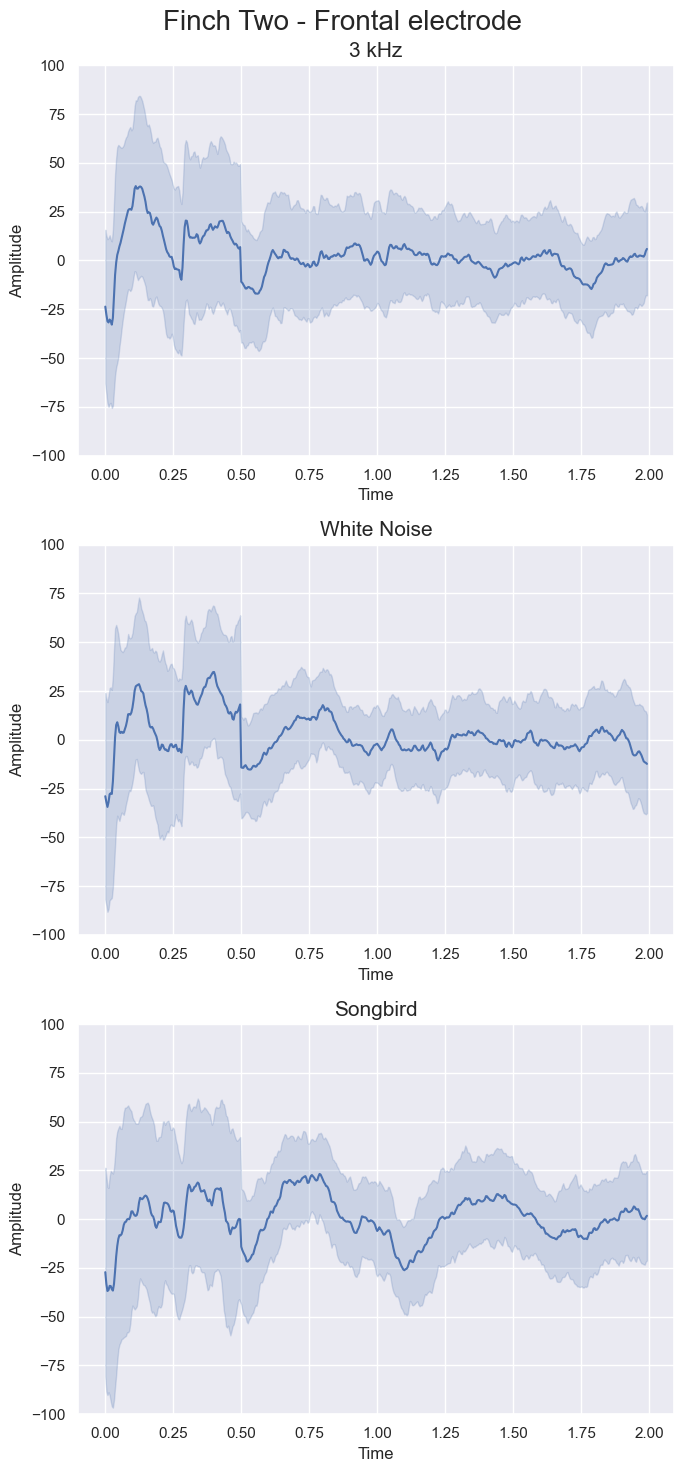

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=(7, 15), tight_layout=False)

# Set titles for each plot
axs[0].plot(np.arange(Epoch25_2.shape[1])/250, np.mean(Epoch25_2, axis=0))
axs[0].fill_between( np.arange(Epoch25_2.shape[1])/250, (np.mean(Epoch25_2, axis=0) - np.std(Epoch25_2, axis =0)), (np.mean(Epoch25_2, axis=0) + np.std(Epoch25_2, axis =0)), color='b', alpha=0.2)
axs[0].set_title('3 kHz', fontsize=15)
axs[0].set_ylim([-100, +100])
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Amplitude')

axs[1].plot(np.arange(Epoch25_2.shape[1])/250,np.mean(Epoch50_2, axis=0))
axs[1].fill_between( np.arange(Epoch25_2.shape[1])/250, (np.mean(Epoch50_2, axis=0) - np.std(Epoch50_2, axis =0)), (np.mean(Epoch50_2, axis=0) + np.std(Epoch50_2, axis =0)), color='b', alpha=0.2)

axs[1].set_title('White Noise', fontsize=15)
axs[1].set_ylim([-100, +100])

axs[1].set_xlabel('Time')
axs[1].set_ylabel('Amplitude')

axs[2].plot(np.arange(Epoch25_2.shape[1])/250,np.mean(Epoch75_2, axis=0))
axs[2].set_title('Songbird', fontsize=15)
axs[2].fill_between( np.arange(Epoch25_2.shape[1])/250, (np.mean(Epoch75_2, axis=0) - np.std(Epoch75_2, axis =0)), (np.mean(Epoch75_2, axis=0) + np.std(Epoch75_2, axis =0)), color='b', alpha=0.2)

axs[2].set_ylim([-100, +100])

axs[2].set_xlabel('Time')
axs[2].set_ylabel('Amplitude')

# Set title for the whole figure
fig.suptitle('Finch Two - Frontal electrode', fontsize=20)
plt.savefig('fig/ERP2_Frontal.eps', format='eps', dpi=700)

plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


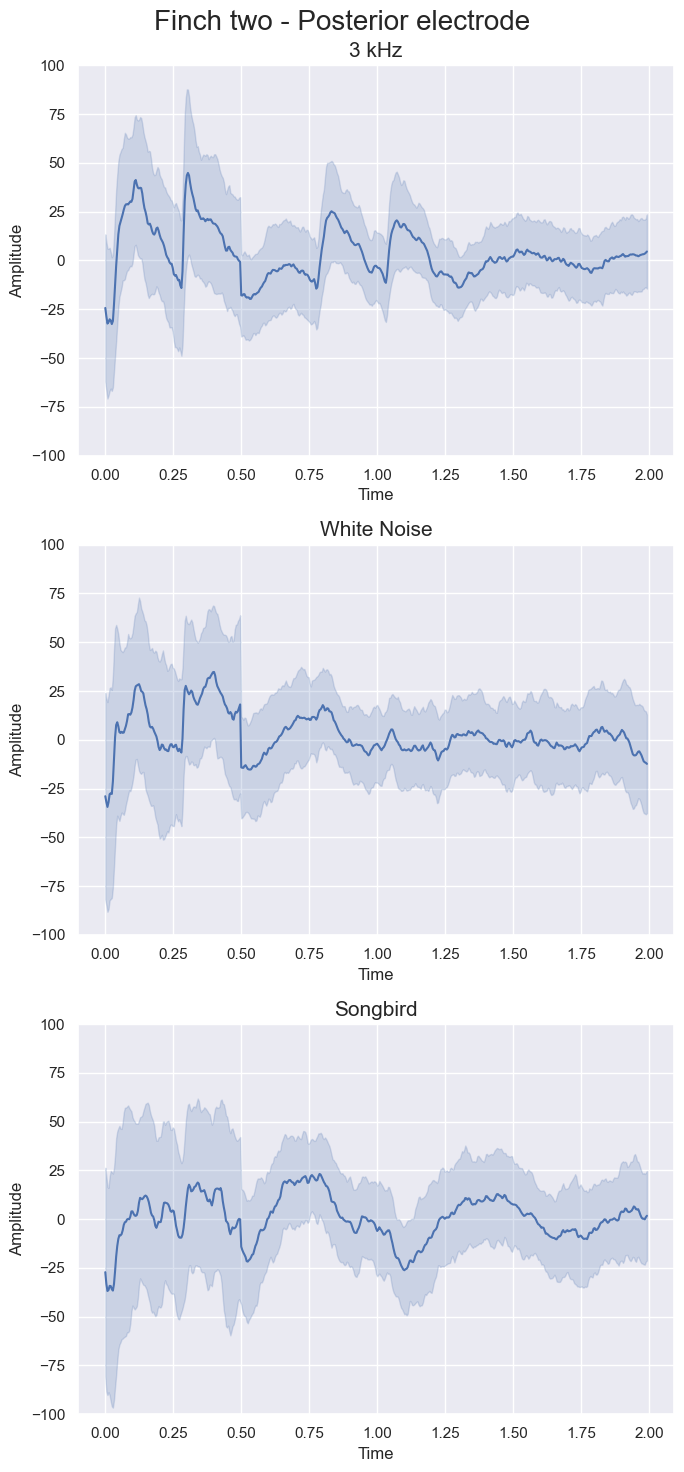

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=(7, 15), tight_layout=False)

# Set titles for each plot
axs[0].plot(np.arange(Epoch25_2.shape[1])/250,np.mean(Epoch255_2, axis=0))
axs[0].fill_between( np.arange(Epoch25_2.shape[1])/250, (np.mean(Epoch255_2, axis=0) - np.std(Epoch255_2, axis =0)), (np.mean(Epoch255_2, axis=0) + np.std(Epoch255_2, axis =0)), color='b', alpha=0.2)
axs[0].set_title('3 kHz', fontsize=15)
axs[0].set_ylim([-100, +100])
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Amplitude')

axs[1].plot(np.arange(Epoch25_2.shape[1])/250,np.mean(Epoch50_2, axis=0))
axs[1].fill_between( np.arange(Epoch25_2.shape[1])/250, (np.mean(Epoch50_2, axis=0) - np.std(Epoch50_2, axis =0)), (np.mean(Epoch50_2, axis=0) + np.std(Epoch50_2, axis =0)), color='b', alpha=0.2)

axs[1].set_title('White Noise', fontsize=15)
axs[1].set_ylim([-100, +100])

axs[1].set_xlabel('Time')
axs[1].set_ylabel('Amplitude')

axs[2].plot(np.arange(Epoch25_2.shape[1])/250,np.mean(Epoch75_2, axis=0))
axs[2].set_title('Songbird', fontsize=15)
axs[2].fill_between( np.arange(Epoch25_2.shape[1])/250, (np.mean(Epoch75_2, axis=0) - np.std(Epoch75_2, axis =0)), (np.mean(Epoch75_2, axis=0) + np.std(Epoch75_2, axis =0)), color='b', alpha=0.2)

axs[2].set_ylim([-100, +100])

axs[2].set_xlabel('Time')
axs[2].set_ylabel('Amplitude')

# Set title for the whole figure
fig.suptitle('Finch two - Posterior electrode', fontsize=20)
plt.savefig('fig/ERP2_posterior.eps', format='eps', dpi=700)

plt.show()

In [ ]:
# Perform permutation test
permutation_p_value = permutation_test(Epoch25_2, Epoch50_2)
print("Permutation Test p-value:", permutation_p_value)

In [ ]:
# Perform permutation test
permutation_p_value = permutation_test(Epoch50_2, Epoch75_2)
print("Permutation Test p-value:", permutation_p_value)

In [ ]:
# Perform permutation test
permutation_p_value = permutation_test(Epoch25_2, Epoch75_2)
print("Permutation Test p-value:", permutation_p_value)

In [ ]:
# Perform permutation test
permutation_p_value = permutation_test(Epoch255_2, Epoch500_2)
print("Permutation Test p-value:", permutation_p_value)

In [ ]:
# Perform permutation test
permutation_p_value = permutation_test(Epoch500_2, Epoch755_2)
print("Permutation Test p-value:", permutation_p_value)

In [ ]:
# Perform permutation test
permutation_p_value = permutation_test(Epoch255_2, Epoch755_2)
print("Permutation Test p-value:", permutation_p_value)

In [ ]:
fig, axs = plt.subplots(3, 1,figsize=(11, 5), tight_layout=True)
plt.title('Finch Two- block Two- Front elecotrode',fontsize = 15)

axs[0].plot(np.mean(Epoch255_2, axis = 0))
axs[1].plot(np.mean(Epoch500_2, axis = 0))
axs[2].plot(np.mean(Epoch755_2, axis = 0))

In [ ]:
print(len(Epoch25_2)+len(Epoch50_2)+len(Epoch75_2)) #checking the trigger count

## SVM and Spectogram

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from scipy.fft import fft, fftfreq
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from scipy.signal import spectrogram



In [ ]:
a2  = np.array(Avg_Epoch2)
a5  = np.array(Avg_Epoch5)
a7  = np.array(Avg_Epoch7)

b2  = np.array(Avg_Epoch22)
b5  = np.array(Avg_Epoch55)
b7  = np.array(Avg_Epoch77)

a2_2  = np.array(Avg_Epoch2_2)
a5_2  = np.array(Avg_Epoch5_2)
a7_2  = np.array(Avg_Epoch7_2)

b2_2  = np.array(Avg_Epoch22_2)
b5_2  = np.array(Avg_Epoch55_2)
b7_2  = np.array(Avg_Epoch77_2)
np.shape(Avg_Epoch2)

In [ ]:
features = np.r_[ a7, a5].reshape(-1,1)
labels = np.r_[np.full(140,1), np.full(140, 2)]


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.4, random_state=42)

# Standardize features by removing the mean and scaling to unit variance
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create an SVM classifier
svm_classifier = SVC(kernel='linear', C=1.0, random_state=42)

# Train the SVM classifier
svm_classifier.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = svm_classifier.predict(X_test_scaled)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

In [ ]:


def compute_power_frequency(epochs, SR = 250):
  
    # Define frequency band ranges
    bands = {
        'delta': (0.5, 4),
        'theta': (4, 8),
        'alpha': (8, 13),
        'beta': (13, 30),
        'gamma': (30, 100)
    }

    num_epochs, num_samples_per_epoch = epochs.shape
    num_bands = len(bands)

    # Initialize array to store power in each band for each epoch
    power_bands = np.zeros((num_epochs, num_bands))

    # Compute power for each epoch
    for i in range(num_epochs):
        epoch = epochs[i, :]
        
        # Compute FFT
        fft_result = fft(epoch)
        freq_bins = fftfreq(num_samples_per_epoch, 1/SR )

        # Compute power in each frequency band
        for j, (band_name, band_range) in enumerate(bands.items()):
            band_power = np.sum(np.abs(fft_result[(freq_bins >= band_range[0]) & (freq_bins < band_range[1])])**2)
            power_bands[i, j] = band_power

    return power_bands




In [ ]:
a = compute_power_frequency(Epoch25)
b = compute_power_frequency(Epoch50)
c = compute_power_frequency(Epoch75)
a2 = compute_power_frequency(Epoch25_2)
b2 = compute_power_frequency(Epoch50_2)
c2 = compute_power_frequency(Epoch75_2)
a3 = compute_power_frequency(Epoch255)
b3 = compute_power_frequency(Epoch500)
c3 = compute_power_frequency(Epoch755)
a4 = compute_power_frequency(Epoch255_2)
b4 = compute_power_frequency(Epoch500_2)
c4 = compute_power_frequency(Epoch755_2)


features = np.r_[ a,a2, a3, a4,c, c2,c3, c4, b, b2, b3, b4]
labels = np.r_[np.full(240,1), np.full(240, 2), np.full(240, 3)]


In [ ]:

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=42)

# Standardize features by removing the mean and scaling to unit variance
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create an SVM classifier
svm_classifier = SVC(kernel='linear', C=1.0, random_state=42)

# Train the SVM classifier
svm_classifier.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = svm_classifier.predict(X_test_scaled)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.4, random_state=42)

# Initialize and train the LDA classifier
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)

# Predict the labels for test data
y_pred = lda.predict(X_test)

# Evaluate the accuracy of the classifier
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


In [ ]:
fft_result = fft(data1[1])

# Frequency bins corresponding to the FFT result
freq_bins = fftfreq(len(data[1]),250)

# Define frequency band ranges (you can adjust these according to your requirements)
delta_band = (0.5, 4)    # Delta band: 0.5 - 4 Hz
theta_band = (4, 8)      # Theta band: 4 - 8 Hz
alpha_band = (8, 13)     # Alpha band: 8 - 13 Hz
beta_band = (13, 30)     # Beta band: 13 - 30 Hz
gamma_band = (30, 100)   # Gamma band: 30 - 100 Hz

# Extract power in each frequency band
delta_power = np.sum(np.abs(fft_result[(freq_bins >= delta_band[0]) & (freq_bins < delta_band[1])])**2)
theta_power = np.sum(np.abs(fft_result[(freq_bins >= theta_band[0]) & (freq_bins < theta_band[1])])**2)
alpha_power = np.sum(np.abs(fft_result[(freq_bins >= alpha_band[0]) & (freq_bins < alpha_band[1])])**2)
beta_power = np.sum(np.abs(fft_result[(freq_bins >= beta_band[0]) & (freq_bins < beta_band[1])])**2)
gamma_power = np.sum(np.abs(fft_result[(freq_bins >= gamma_band[0]) & (freq_bins < gamma_band[1])])**2)

# Plot the FFT result (optional)
plt.plot(freq_bins, np.abs(fft_result))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.title('FFT of EEG Epoch')
plt.show()

# Print power in each frequency band
print("Delta Power:", delta_power)
print("Theta Power:", theta_power)
print("Alpha Power:", alpha_power)
print("Beta Power:", beta_power)
print("Gamma Power:", gamma_power)

In [ ]:
Epoch25 = Epoch25.astype(float)
Epoch50 = Epoch50.astype(float)

In [ ]:
f, t, Sxx = signal.spectrogram(Epoch25[0], 250)
plt.pcolormesh(t, f, 10 * np.log10(Sxx), shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

In [ ]:

fs = 250
# Compute spectrogram for each epoch
spectrograms = []
for epoch in range(len(Epoch25)):
    frequencies, times, Sxx = spectrogram(Epoch25[epoch], fs)
    spectrograms.append(Sxx)

# Plot spectrograms for each epoch
plt.figure(figsize=(12, 6))
for epoch in range(len(Epoch25)):
    plt.subplot(10, 10, epoch+1)
    plt.pcolormesh(times, frequencies, 10 * np.log10(spectrograms[epoch]), shading='gouraud')
    plt.title('Epoch {}'.format(epoch+1),fontsize = 5)
    plt.xlabel('Time (s)',fontsize = 5)
    plt.ylabel('Frequency (Hz)',fontsize = 5)
    plt.colorbar().set_label('Power (dB)',fontsize = 5)
    plt.tick_params(axis='both', which='major', labelsize=5)  # Set size of major tick labels
    plt.tick_params(axis='both', which='minor', labelsize=5)
plt.tight_layout()
plt.show()


In [ ]:

# Compute spectrogram for each epoch
spectrograms = []
for epoch in range(len(Epoch50)):
    frequencies, times, Sxx = spectrogram(Epoch50[epoch], fs)
    spectrograms.append(Sxx)

# Plot spectrograms for each epoch
plt.figure(figsize=(12, 6))
for epoch in range(len(Epoch50)):
    plt.subplot(10, 10, epoch+1)
    plt.pcolormesh(times, frequencies, 10 * np.log10(spectrograms[epoch]), shading='gouraud')
    plt.title('Epoch {}'.format(epoch+1),fontsize = 5)
    plt.xlabel('Time (s)',fontsize = 5)
    plt.ylabel('Frequency (Hz)',fontsize = 5)
    plt.colorbar().set_label('Power (dB)',fontsize = 5)
    plt.tick_params(axis='both', which='major', labelsize=5)  # Set size of major tick labels
    plt.tick_params(axis='both', which='minor', labelsize=5)
plt.tight_layout()
plt.show()


# Coherency 

In [ ]:

from scipy.signal import correlate, coherence
from scipy.fft import fftshift

# Simulate two signals
np.random.seed(0)  # For reproducibility
fs = 1000  # Sampling frequency in Hz
t = np.arange(0, 1, 1/fs)  # 1 second of data
signal_freq = 5  # Frequency of the signals in Hz

# Signal A is a sine wave
signal_a = np.sin(2 * np.pi * signal_freq * t)
# Signal B is a sine wave delayed by 0.1 seconds relative to Signal A
delay = 0.1  # 100 ms delay
signal_b = np.sin(2 * np.pi * signal_freq * (t - delay))

# Add some noise
noise_level = 0.5
signal_a += noise_level * np.random.randn(len(t))
signal_b += noise_level * np.random.randn(len(t))

# Cross-Correlation Analysis
lags = np.arange(-len(t) + 1, len(t))
corr = correlate(signal_b, signal_a, mode='full')
corr /= np.max(corr)  # Normalize

# Find the lag with the highest correlation
lag_max = lags[np.argmax(corr)]




In [ ]:
plt.plot(corr)

In [ ]:
# Coherence Analysis
frequencies, coh = coherence(signal_a, signal_b, fs=fs, nperseg=256)

# Plotting
plt.figure(figsize=(18, 6))

# Plot signals
plt.subplot(1, 3, 1)
plt.plot(t, signal_a, label='Signal A')
plt.plot(t, signal_b, label='Signal B')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.title('Signals')

# Plot Cross-Correlation
plt.subplot(1, 3, 2)
plt.plot(lags/fs, corr)
plt.axvline(x=lag_max/fs, color='r', linestyle='--', label=f'Lag: {lag_max/fs:.2f}s')
plt.xlabel('Lag (s)')
plt.ylabel('Normalized Cross-Correlation')
plt.legend()
plt.title('Cross-Correlation')

# Plot Coherence
plt.subplot(1, 3, 3)
plt.semilogy(frequencies, coh)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Coherence')
plt.title('Coherence Analysis')

plt.tight_layout()
plt.show()

# Output the lag with the highest correlation
print(f"The lag with the highest correlation is {lag_max/fs:.2f} seconds.")

In [ ]:
np.shape(Epoch25)


In [ ]:
def corr_epoch(sig1, sig2 , n_epoch = 20):
    Correlation = [] 
    for i in range(n_epoch):    
        Correlation.append(signal.correlate(sig1[i], sig2[i]))
    Correlation = np.asarray(Correlation)/ np.max(np.asarray(Correlation))
    Correlation =np.reshape(Correlation, (n_epoch,497))
    
    return np.mean( Correlation , axis =0)

In [ ]:
corr25 = corr_epoch (Epoch25 , Epoch255)
lags = signal.correlation_lags(len(Epoch25[1]), len(Epoch255[1]))
plt.plot(lags, corr25)
lag_max = lags[np.argmax(corr25)]
print(lag_max)

In [ ]:
corr50 = corr_epoch (Epoch50 , Epoch500)
lags = signal.correlation_lags(len(Epoch25[1]), len(Epoch255[1]))
plt.plot(lags, corr50)
lag_max5 = lags[np.argmax(corr50)]
print(lag_max5)

In [ ]:
corr75 = corr_epoch (Epoch75 , Epoch755)
lags = signal.correlation_lags(len(Epoch25[1]), len(Epoch255[1]))
plt.plot(lags, corr75)
lag_max7 = lags[np.argmax(corr75)]
print(lag_max7)

In [ ]:
fig, (ax_orig, ax_noise, ax_corr) = plt.subplots(3, 1, figsize=(4.8, 4.8))
ax_orig.plot(Epoch25[1])
ax_orig.set_title('Original signal')
ax_orig.set_xlabel('Sample Number')
ax_noise.plot(Epoch255[1])
ax_noise.set_title('Signal with noise')
ax_noise.set_xlabel('Sample Number')
ax_corr.plot(lags, corr25)
ax_corr.set_title('Cross-correlated signal')
ax_corr.set_xlabel('Lag')
ax_orig.margins(0, 0.1)
ax_noise.margins(0, 0.1)
ax_corr.margins(0, 0.1)
fig.tight_layout()
plt.show()

In [ ]:
Epoch25[1]

In [ ]:
frequencies, coh = coherence(Epoch25[1], Epoch255[1], fs=250, nperseg=256)
coh

In [ ]:
f, Cxy = signal.coherence(Epoch25[2], Epoch255[2], fs = 250, nperseg=1024)
plt.semilogy(f, Cxy)
plt.xlabel('frequency [Hz]')
plt.ylabel('Coherence')
plt.show()

In [ ]:
rng = np.random.default_rng()

fs = 10e3
N = 1e5
amp = 20
freq = 1234.0
noise_power = 0.001 * fs / 2
time = np.arange(N) / fs
b, a = signal.butter(2, 0.25, 'low')
x = rng.normal(scale=np.sqrt(noise_power), size=time.shape)
y = signal.lfilter(b, a, x)
x += amp*np.sin(2*np.pi*freq*time)
y += rng.normal(scale=0.1*np.sqrt(noise_power), size=time.shape)

In [ ]:
f, Cxy = signal.coherence(x, y, fs, nperseg=1024)
plt.semilogy(f, Cxy)
plt.xlabel('frequency [Hz]')
plt.ylabel('Coherence')
plt.show()

In [ ]:
Cxy